In [1]:
!pip install -e ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2

Obtaining file:///home/nannau/climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
  Running setup.py develop for climpyrical
You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [78]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
dsold = read_data(PATH, dv)

NNN = 3
ds = regrid_ensemble(dsold, dv, NNN)


In [79]:
shape = ds[dv].values[0, ...].shape

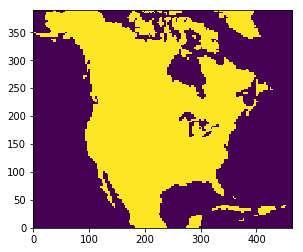

In [80]:
mask = read_data('/home/nannau/climpyrical/climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', design_value_name='sftlf', keys={'rlat', 
'rlon'})
dvmask = 'sftlf'
# mask
mask = mask.squeeze('time')
mask = mask.drop('time')
mask = regrid_ensemble(mask, 'sftlf', NNN, keys={'rlat', 'rlon'})
mask = mask[dvmask].values >= 1.0
plt.imshow(mask, origin='lower')

In [81]:
ens_mean = np.mean(ds[dv].values, axis=0)
ens_mean.shape

(390, 465)

In [82]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

In [83]:
df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)
station_dv = 'RL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)
df = df[df[station_dv] != 0.0]

# Add nearest rlon and rlat locations in grid to stations
rlon_nearest_index, rlat_nearest_index = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# df = df.assign(
#         rlon=rlon[rlat_nearest_index, rlon_nearest_index], 
#         rlat=rlat[rlat_nearest_index, rlon_nearest_index]
# )

df = df.assign(
    label='stations',
    rlon_nearest_index = rlon_nearest_index, 
    rlat_nearest_index = rlat_nearest_index,
    nearest_grid = list(zip(rlon_nearest_index, rlat_nearest_index))
)

# Group together stations falling in same grid cell and take mean
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                station_dv: 'mean',
                                'lat':'mean',
                                'lon':'mean',
                                'rlat': 'mean',
                                'rlon': 'mean',
                                'rlon_nearest_index':'mean',
                                'rlat_nearest_index':'mean',
                                'label': 'min',
                            })

# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

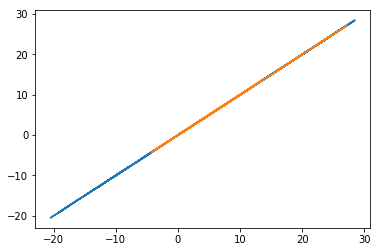

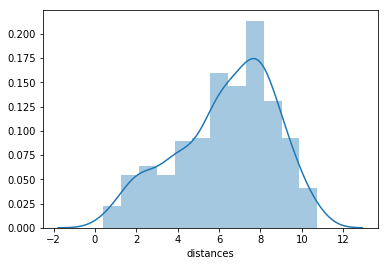

In [84]:
plt.plot(rlon[rlat_nearest_index, rlon_nearest_index], df.rlon.values)
plt.plot(rlat[rlat_nearest_index, rlon_nearest_index], df.rlat.values)
plt.show()

from sklearn.metrics import pairwise_distances_argmin_min

distance_to_nearest_gridcell = pairwise_distances_argmin_min( 
    np.deg2rad(np.stack([ndf.rlon, ndf.rlat]).T), 
    np.deg2rad(
        np.stack([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    ),
    metric='haversine'
    
)[1]*6371000/1000
ndf['distances']=distance_to_nearest_gridcell
sns.distplot(ndf['distances'])

In [85]:
find_nearest_index_value?

Signature: find_nearest_index_value(station_vals, x, y, x_i, y_i, field, mask, ds)
Docstring:
Finds the nearest model value to a station location in the CanRCM4
grid space
Args:
    x, y (np.ndarray): monotonically increasing array of column
        or rowcoordinates
    x_i, y_i (np.ndarray): indices in the rlon and rlat arrays
        of the closest grid to stations
    field (np.ndarray): 2 dimensional field array containing
        the CanRCM4 field
    mask (np.ndarray of bool): 2 dimensional mask array matching field
        with a boolean mask of accepted values for analyses
    ds (xarray.core.dataset.Dataset): dataset containing the ensemble for
        checking consistency with ensemble
Raises:
    TypeError, ValueError in check_find_nearest_value_inputs
    TypeError:
            If arrays are not of type np.ndarray
    ValueError:
            If field provided is not made of x and y coordinates
            If field shape and mask shapes are different
            If x and y 

In [157]:
X = np.stack([df.rlon.values, df.rlat.values]).T

# rlat_nearest_index, rlon_nearest_index

X = np.stack(
        [
            rlon[rlat_nearest_index, rlon_nearest_index], 
            rlat[rlat_nearest_index, rlon_nearest_index]
        ]
).T

Xf = np.stack(
        [
            rlon[final_mask], 
            rlat[final_mask]
        ]
).T

model_arr = np.array(
                [
                    ds[dv].values.copy()[i, rlat_nearest_index, rlon_nearest_index] for i in range(35)
                ]
)

model_arr = np.array([find_nearest_index_value(df[station_dv].values, ds.rlon.values, ds.rlat.values, rlon_nearest_index, rlat_nearest_index, ds[dv].values[i, ...], final_mask, ds) for i in range(35)])

ratio = df[station_dv].values/model_arr

ratio.shape, X.shape

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


((35, 378), (378, 2))

In [158]:
assert np.all([np.isclose(model_arr[:, i], ds[dv].values.copy()[:, rlat_nearest_index[i], rlon_nearest_index[i]]) for i in range(rlon_nearest_index.size)])

In [159]:
ds[dv].values.copy()[:, final_mask].shape

(35, 71928)

In [160]:
ds[dv].values.copy()[:, final_mask].shape

(35, 71928)

In [161]:
np.any(np.isnan(Xf)), np.any(np.isnan(X)), np.any(np.isnan(ratio)), np.any(np.isnan(model_arr))

(False, False, False, False)

In [162]:
%%time
warnings.filterwarnings('ignore')
predlist = []
predfull = []
params_fit = []
parameters = {'n_neighbors': range(2, 50)}

model = KNeighborsRegressor(weights='distance')
clf = GridSearchCV(model, parameters, cv=10)

for i in range(35):
    clf = GridSearchCV(model, parameters, cv=10)
    model = KNeighborsRegressor(weights='distance')
    clf.fit(X, ratio[i, ...])
    predlist.append(clf.predict(X))
    predfull.append(clf.predict(Xf))
#     print(clf.score(X, ratio[i, ...]))
    params_fit.append(clf.best_params_)

CPU times: user 25.9 s, sys: 101 ms, total: 26 s
Wall time: 26 s


In [163]:
78-35

43

In [164]:
preds = np.array(predlist)
preds = preds*model_arr
predsfull = np.array(predfull)*ds[dv].values[:, final_mask]

np.isin(model_arr, ds[dv].values)

preds.shape, predsfull.shape

np.sum(np.isnan(ratio[0, :])), np.sum(np.isin(preds[0, :], predsfull[0, :])), np.sum(np.isin(rlon[rlat_nearest_index, rlon_nearest_index], rlon[final_mask])), preds[0,:].size

(0, 326, 377, 378)

15

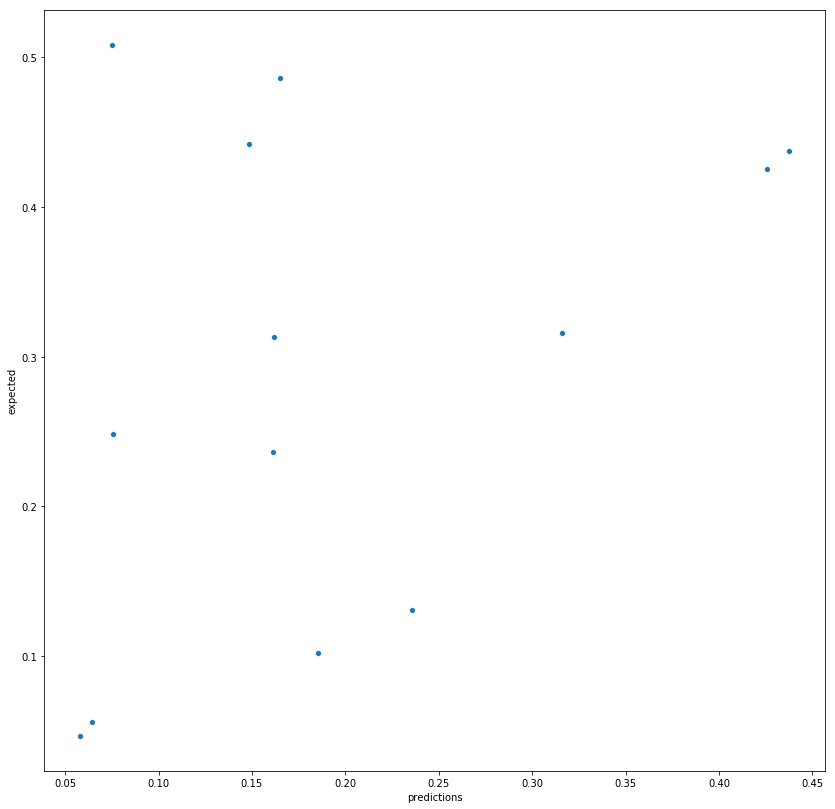

In [172]:
S = ds[dv].values.copy()

S[:, final_mask] = predsfull
# S[:, ~final_mask] = np.nan

# S[:, final_mask] = predfull

# S[:, rlat_nearest_index, rlon_nearest_index] = preds
# for i in range(35):
#       plt.scatteRr
plt.figure(figsize=(14, 14))
# plt.scatter(S[0, rlat_nearest_index, rlon_nearest_index], preds[0, :])
#     plt.scatter(S[i, final_mask], ds[dv].values[i, final_mask], s=0.2)
#     plt.scatter(preds[i, :]*model_arr[i, :], ratio[i, :]*model_arr[i, :], s=0.2)
#     plt.scatter(S[i, rlat_nearest_index, rlon_nearest_index], ratio[i, :], s=0.2)
    
#     plt.scatter(S[i, rlat_nearest_index, rlon_nearest_index], df[station_dv])
plt.xlabel('predictions')
plt.ylabel('expected')

weird = ~np.isclose(S[0, rlat_nearest_index, rlon_nearest_index]/df[station_dv], 1.0, atol=0.1)
sns.scatterplot(S[0, rlat_nearest_index, rlon_nearest_index][weird], preds[0, weird])
np.sum(~weird), weird.size, np.sum(weird)
S[0, rlat_nearest_index, rlon_nearest_index][weird].size

In [166]:
np.sum(weird)

15

In [167]:
ds.coords

Coordinates:
  * rlat     (rlat) float64 -28.75 -28.6 -28.45 -28.31 ... 28.01 28.16 28.31
  * rlon     (rlon) float64 -34.03 -33.88 -33.73 -33.59 ... 33.73 33.88 34.03
    lat      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    lon      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan
  * level    (level) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35

In [168]:
np.sum(~weird)

363

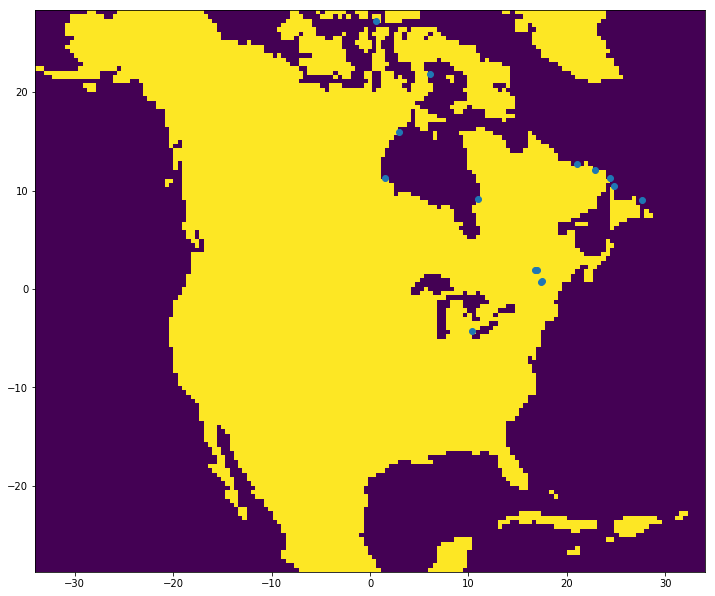

In [171]:
plt.figure(figsize=(12,12))
plt.scatter(df.rlon.values[weird], df.rlat.values[weird])
plt.imshow(mask, origin='lower', extent=[ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()])
plt.savefig('incorrect_reconstructions.png')

In [289]:
# assert np.all([np.isclose(mean_squared_error(preds[i, ...], df[station_dv]), 0.) for i in range(35)])


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [ ]:
ks = np.array([t['n_neighbors'] for t in params_fit])
ks

In [261]:

model = KNeighborsRegressor(n_neighbors=9, weights='distance')
model.fit(X, ratio[0, ...])

def pwhole_(alpha, k, Y):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))
    a = np.array([rlon[final_mask], rlat[final_mask]]).T
    a1 = np.array([df['rlon'].values, df['rlat'].values]).T
#     a1 = np.array([rlon[rlat_i_agg, rlon_i_agg], rlat[rlat_i_agg, rlon_i_agg]]).T
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X, Y)
    d = model.kneighbors_graph(a, mode='distance').toarray()
    fracs = np.linspace(0.2, -5)
    residual = []
    residual_plain = []
    residual_inv=[]
    psumar=[]

    denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
    num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = num/denom
    pwhole = ens_mean.copy()
    pwhole[final_mask] = p
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(ens_mean.shape)

In [262]:
stations, mean = [], []
fracs = np.linspace(-1, 5, 30)

for frac in fracs:
    pwhole = pwhole_(frac, ks, )
    
    values = np.stack([ndf.rlon, ndf.rlat])
    ndf['ratio'] = ndf[station_dv]/ndf.mean_values
    
    final = ens_mean.copy()
    Xfull = np.stack([rlon[final_mask], rlat[final_mask]])
    predfull = model.predict(Xfull.T)
    final[final_mask] = predfull
    final = ((np.ones(ens_mean.shape)-pwhole) + pwhole*final)*ens_mean

    final[~final_mask] = np.nan


    pred = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, final.copy(), final_mask, ds)
    station_vals = ndf['ratio'].values*ndf.mean_values
    stations.append(np.sqrt(mean_squared_error(station_vals, pred))) 

TypeError: pwhole_() missing 2 required positional arguments: 'k' and 'Y'